Importing everything we'll be using to examine the data.

In [23]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import requests, os, time

Using the dataset from NPS Mortality Dashboard to create df using pandas function to import first the file, and then parse to only show the sheet that has the data.   

In [43]:
df = pd.ExcelFile(r"../data/NPS-Mortality-Data-CY2007-to-CY2024-Released-August-2024.xlsx")
df = df.parse(sheet_name="CY2007-Present Q2")
df.head()

,Incident Date,Park Name,Cause of Death,Cause of Death Group \n(Used in the NPS Mortality Dashboard),Intent,Outcome,Sex,Age Range,Activity
0,2007-01-01,Glen Canyon National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,65+,Not Reported
1,2007-01-22,Golden Gate National Recreation Area,Drowning,Drowning,Unintentional,Fatal injury,Male,Not Reported,Vessel Related
2,2007-01-22,Golden Gate National Recreation Area,Undetermined,Undetermined,Undetermined,Fatal injury,Male,Not Reported,Vessel Related
3,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,15-24,Driving
4,2007-01-29,Natchez Trace Parkway,Motor Vehicle Crash,Motor Vehicle Crash,Unintentional,Fatal injury,Female,45-54,Driving


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4635 entries, 0 to 4634
Data columns (total 9 columns):
 #   Column                                                        Non-Null Count  Dtype         
---  ------                                                        --------------  -----         
 0   Incident Date                                                 4635 non-null   datetime64[ns]
 1   Park Name                                                     4635 non-null   object        
 2   Cause of Death                                                4635 non-null   object        
 3   Cause of Death Group 
(Used in the NPS Mortality Dashboard)   4635 non-null   object        
 4   Intent                                                        4635 non-null   object        
 5   Outcome                                                       4635 non-null   object        
 6   Sex                                                           4635 non-null   object        
 7   Age Ran

In [34]:
df.describe()

,Incident Date
count,4635
mean,2017-02-02 12:31:13.398058240
min,2007-01-01 00:00:00
25%,2014-03-24 00:00:00
50%,2017-07-19 00:00:00
75%,2020-09-25 00:00:00
max,2024-06-29 00:00:00


In [10]:
print(df.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity'],
      dtype='object')


In [12]:
print(df.columns.tolist())


['Incident Date', 'Park Name', 'Cause of Death', 'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ', 'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity']


Now that I know the column names, I'm going to make a pie chart with the percentage of deaths by cause. I think this is a good visual starting place to see if there are some major causes we could look at more closely.

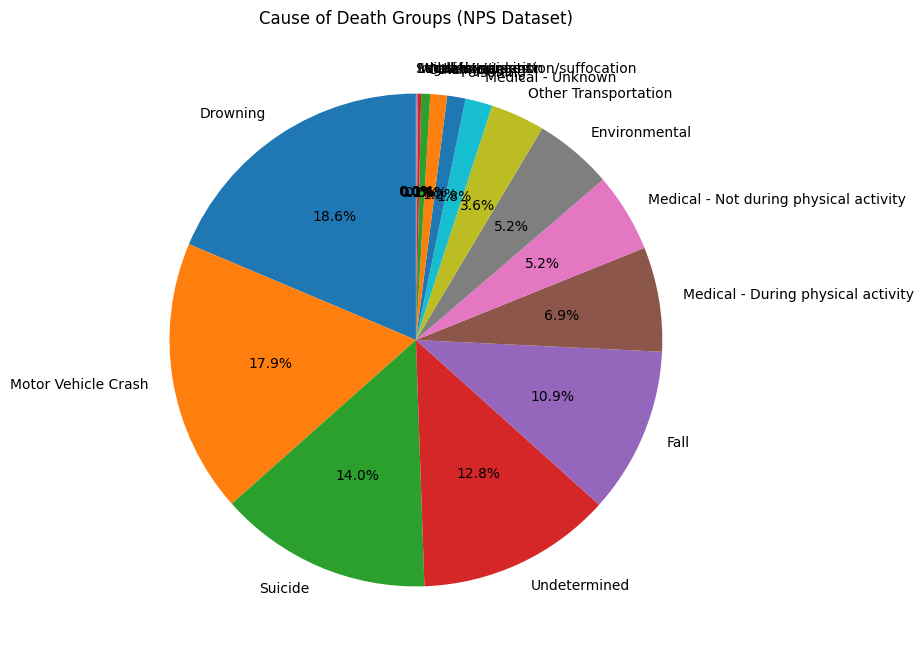

In [13]:
cause_counts = df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "].value_counts()

cause_counts.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8,8),
    startangle=90
)

plt.ylabel("")
plt.title("Cause of Death Groups (NPS Dataset)")
plt.show()


We can see some major common causes, but there are also a lot of less common causes that you can't really read on the pie chart. I'm going to look at the data to combine some of the smaller sections into one "other" piece.

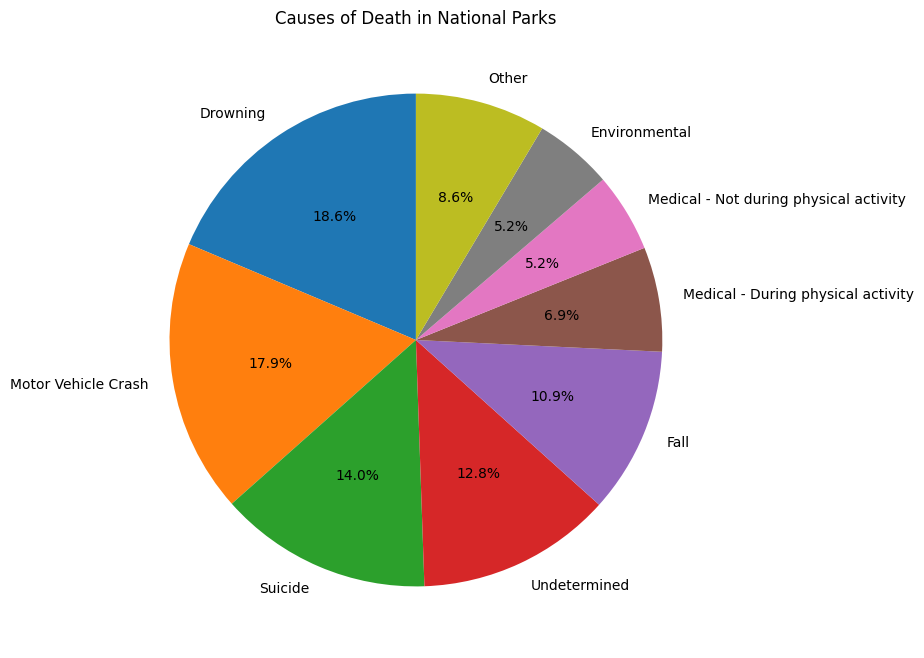

In [19]:
# Step 1: Count values
cause_counts = df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "].value_counts()

# Step 2: Convert to percentages
percentages = cause_counts / cause_counts.sum() * 100

# Step 3: Separate into major vs. small (<5%)
major_causes = percentages[percentages >= 5]
other_total = percentages[percentages < 5].sum()

if other_total > 0:
    major_causes["Other"] = other_total

# Step 4: Plot
major_causes.plot(
    kind="pie",
    autopct="%1.1f%%",
    figsize=(8, 8),
    startangle=90
)

plt.ylabel("")
plt.title("Causes of Death in National Parks")
plt.show()


We can see that the most common cause of death is drowning. Let's look at the drowning deaths by park to see if there are any parks that seem more dangerous than others.

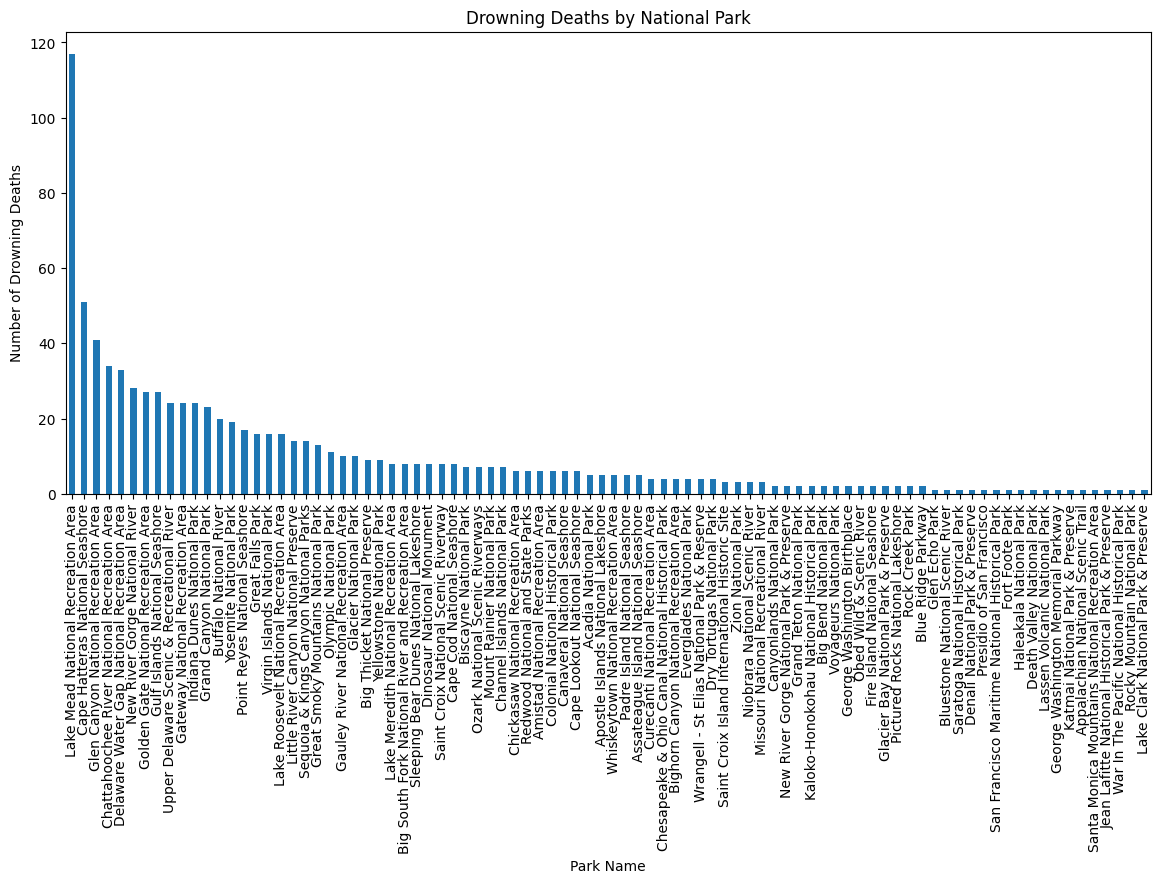

In [ ]:
#Filter for drowning
drowning_df = df[df["Cause of Death Group \n(Used in the NPS Mortality Dashboard) "] == "Drowning"]

#Count drowning deaths in parks
drowning_counts = drowning_df["Park Name"].value_counts()

#Create bar graph with data
plt.figure(figsize=(14,6))
drowning_counts.plot(kind="bar")

plt.title("Drowning Deaths by National Park")
plt.xlabel("Park Name")
plt.ylabel("Number of Drowning Deaths")
plt.xticks(rotation=90)

plt.show()




THere are a lot of parks with many deaths, but most only have a few. It's hard to look at the data this way with so many parks. I'm going to make a new chart that just shows the 15 highest parks.

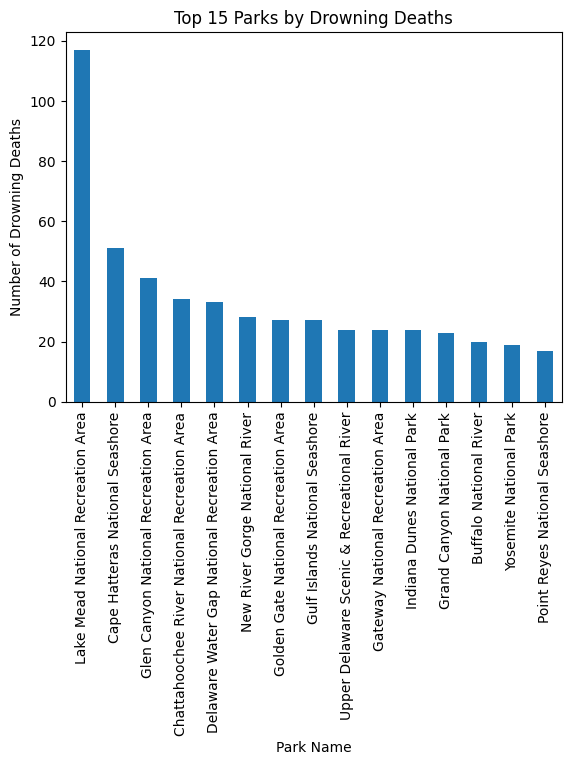

In [27]:
top_drowning = drowning_counts.head(15)

top_drowning.plot(kind="bar")
plt.title("Top 15 Parks by Drowning Deaths")
plt.xlabel("Park Name")
plt.ylabel("Number of Drowning Deaths")
plt.xticks(rotation=90)
plt.show()


Flip the axis for greater readability. Sort values to put highest deaths on the top. Remove y axis label for readability.

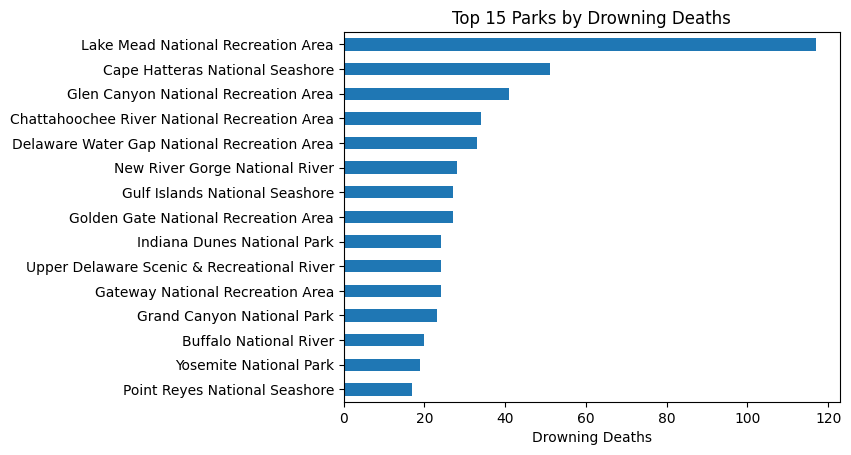

In [32]:
top_drowning = drowning_counts.head(15).sort_values()

top_drowning.plot(kind="barh")
plt.title("Top 15 Parks by Drowning Deaths")
plt.xlabel("Drowning Deaths")
plt.ylabel("")
plt.xticks(rotation=0)
plt.show()

I'm going to try to access the database with information about the parks visitor statistics and see what info I can get about a specific park.

In [ ]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv(), override=True)
API_KEY = os.getenv("NPS_API_KEY")

# check if it loaded successfully
print(API_KEY is not None)  

True


Trying to search for "Lake Mead" to see if I can make requests with park names. It didn't return the correct park so I can't search this way.

In [29]:

NPS_BASE = "https://developer.nps.gov/api/v1/parks"

# search by name
params = {"q": "lake mead", "limit": 10, "api_key": API_KEY}
r = requests.get(NPS_BASE, params=params, timeout=30)
r.raise_for_status()
data = r.json()["data"]
# Grab name + code from the first hit
full_name = data[0]["fullName"]
park_code = data[0]["parkCode"]
print(full_name, park_code)


Alibates Flint Quarries National Monument alfl


In [ ]:
BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)
print(r.status_code) 


200


Requesting list of keys for data returned so I can see how to filter for the park code and the full name.

In [28]:
BASE = "https://developer.nps.gov/api/v1/parks"
params = {"limit": 50, "start": 0, "api_key": API_KEY}
r = requests.get(BASE, params=params, timeout=30)

if data:
    print(list(data[0].keys()))

['id', 'url', 'fullName', 'parkCode', 'description', 'latitude', 'longitude', 'latLong', 'activities', 'topics', 'states', 'contacts', 'entranceFees', 'entrancePasses', 'fees', 'directionsInfo', 'directionsUrl', 'operatingHours', 'addresses', 'images', 'weatherInfo', 'name', 'designation', 'multimedia', 'relevanceScore']


In [35]:
#Define a function to get info from the parks database
#key = string, page size should be a number, and the pause should be a float, the result should be a pandasee dataframe
def fetch_all_parks(api_key: str, page_size: int = 50, pause: float = 0.2) -> pd.DataFrame:
    base = "https://developer.nps.gov/api/v1/parks"
    start = 0
    rows = []

#Create a loop that will continue until there is no data or the data returned is < the page size
    while True:
        params = {"limit": page_size, "start": start, "api_key": api_key}
        resp = requests.get(base, params=params, timeout=30)
        resp.raise_for_status()
        #convert the response from JSON text to Python dictionary
        payload = resp.json()

        data = payload.get("data", [])
        if not data:
            break
        
        #The default parks response has more info than I need, so I'm going to filter just for the name and park code
        for item in data:
            rows.append({
                "fullName": item.get("fullName"),
                "parkCode": item.get("parkCode")
            })

        if len(data) < page_size:
            break

        start += page_size
        time.sleep(pause)

    return pd.DataFrame(rows).drop_duplicates().reset_index(drop=True)

df_parks = fetch_all_parks(API_KEY, page_size=50)
df_parks.head()


,fullName,parkCode
0,Abraham Lincoln Birthplace National Historical...,abli
1,Acadia National Park,acad
2,Adams National Historical Park,adam
3,African American Civil War Memorial,afam
4,African Burial Ground National Monument,afbg


Saving the data with park names and park codes to a .csv file

In [37]:
print("Number of parks:", len(df_parks))
df_parks.to_csv("nps_parks_fullName_parkCode.csv", index=False)


Number of parks: 474


Looking at new dataframe.

In [40]:
df_parks.info(
)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 474 entries, 0 to 473
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fullName  474 non-null    object
 1   parkCode  474 non-null    object
dtypes: object(2)
memory usage: 7.5+ KB


In [41]:
df_parks.tail()

,fullName,parkCode
469,Yorktown Battlefield Part of Colonial National...,york
470,Yosemite National Park,yose
471,Yucca House National Monument,yuho
472,Yukon - Charley Rivers National Preserve,yuch
473,Zion National Park,zion


Concatenate the two dataframes

In [45]:
df_with_codes = df.copy()
df_with_codes["fullName"] = None
df_with_codes["parkCode"] = None

df_combined = pd.concat([df_with_codes, df_parks], ignore_index=True)

print(df_combined.head())
print(df_combined.tail())

  Incident Date                             Park Name       Cause of Death  \
0    2007-01-01  Glen Canyon National Recreation Area         Undetermined   
1    2007-01-22  Golden Gate National Recreation Area             Drowning   
2    2007-01-22  Golden Gate National Recreation Area         Undetermined   
3    2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   
4    2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   

  Cause of Death Group \n(Used in the NPS Mortality Dashboard)   \
0                                       Undetermined              
1                                           Drowning              
2                                       Undetermined              
3                                Motor Vehicle Crash              
4                                Motor Vehicle Crash              

          Intent       Outcome     Sex     Age Range        Activity fullName  \
0   Undetermined  Fatal injury    Male         

In [46]:
print(df_combined)

     Incident Date                             Park Name       Cause of Death  \
0       2007-01-01  Glen Canyon National Recreation Area         Undetermined   
1       2007-01-22  Golden Gate National Recreation Area             Drowning   
2       2007-01-22  Golden Gate National Recreation Area         Undetermined   
3       2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   
4       2007-01-29                 Natchez Trace Parkway  Motor Vehicle Crash   
...            ...                                   ...                  ...   
5104           NaT                                   NaN                  NaN   
5105           NaT                                   NaN                  NaN   
5106           NaT                                   NaN                  NaN   
5107           NaT                                   NaN                  NaN   
5108           NaT                                   NaN                  NaN   

     Cause of Death Group \

I'm going to try to combine rows that are an exact match without normalizing the names, just to see how many don't have matches.

In [ ]:
#print the column names in the concatenated df
print(df_combined.columns)

Index(['Incident Date', 'Park Name', 'Cause of Death',
       'Cause of Death Group \n(Used in the NPS Mortality Dashboard) ',
       'Intent', 'Outcome', 'Sex', 'Age Range', 'Activity', 'fullName',
       'parkCode'],
      dtype='object')


I'm using the columns to create a set of names for the original "Park Name" and the new "fullName"

In [49]:
park_names = set(df_combined["Park Name"].dropna().unique())
full_names = set(df_combined["fullName"].dropna().unique())


Comparing  the sets to see how many don't have matches. There are lots of parks and park codes that don't have matches, but this is expected as not all parks have recorded deaths in the dataset. There are only 14 Park Names that don't have exact matches.

In [50]:
matches = park_names & full_names   # names that appear in both columns
only_in_parks = park_names - full_names
only_in_full = full_names - park_names

print("Total Park Name values:", len(park_names))
print("Total fullName values:", len(full_names))
print("Exact matches:", len(matches))
print("Only in Park Name:", len(only_in_parks))
print("Only in fullName:", len(only_in_full))


Total Park Name values: 203
Total fullName values: 474
Exact matches: 189
Only in Park Name: 14
Only in fullName: 285


I want to see the list that didn't have a match.

In [51]:
list(only_in_parks)

['Wrangell - St Elias National Park & Reserve',
 'National Mall & Memorial Parks',
 'Big South Fork National River and Recreation Area',
 'Kaloko-Honokohau National Historical Park',
 'George Washington Birthplace',
 'Castillo De San Marcos National Monument',
 'Hawaii Volcanoes National Park',
 'Not Reported',
 'Jean Lafitte National Historical Park & Preserve',
 'Haleakala National Park',
 'New River Gorge National River',
 'Canyon De Chelly National Monument',
 'Suitland',
 "President's Park (White House)"]

I won't be able to match 'Not Reported', so I'm going to exclude that on the list that need matches.

In [52]:
only_in_parks = [nm for nm in only_in_parks if nm != "Not Reported"]


Reprint list to ensure this has been excluded.

In [53]:
list(only_in_parks)

['Wrangell - St Elias National Park & Reserve',
 'National Mall & Memorial Parks',
 'Big South Fork National River and Recreation Area',
 'Kaloko-Honokohau National Historical Park',
 'George Washington Birthplace',
 'Castillo De San Marcos National Monument',
 'Hawaii Volcanoes National Park',
 'Jean Lafitte National Historical Park & Preserve',
 'Haleakala National Park',
 'New River Gorge National River',
 'Canyon De Chelly National Monument',
 'Suitland',
 "President's Park (White House)"]

Now I'm going to normalize the names and see if there are any more matches. I probably should've done this from the start.

In [59]:
def norm(s):
    if s is None:
        return None
    s = str(s).lower().strip()
    return " ".join(s.split())  # collapse multiple spaces


In [60]:
# unique official names
parks_unique = df_parks.dropna(subset=["fullName"]).drop_duplicates(subset=["fullName"]).copy()

# add a normalized key
parks_unique["_key"] = parks_unique["fullName"].map(norm)

# drop any weird Nones and duplicates of the key
parks_unique = parks_unique.dropna(subset=["_key"]).drop_duplicates(subset=["_key"])

# a dict: normalized name -> (official fullName, parkCode)
key_to_official = dict(
    zip(parks_unique["_key"], zip(parks_unique["fullName"], parks_unique["parkCode"]))
)

# our search choices (normalized official names)
choices_norm = list(key_to_official.keys())


Creating the list and using a for loop to compare the normalized names. This will also show us the number remaining after they compare. 

In [61]:
# ensure we have a plain Python list
targets = list(only_in_parks)

exact_hits = []
still_todo = []
for name in targets:
    k = norm(name)
    if k in key_to_official:               # normalized exact match
        full, code = key_to_official[k]
        exact_hits.append((name, full, code, 1.0))  # score 1.0 = perfect
    else:
        still_todo.append(name)

len(exact_hits), len(still_todo)


(2, 12)

In [63]:
print(list(still_todo))

['Wrangell - St Elias National Park & Reserve', 'National Mall & Memorial Parks', 'Big South Fork National River and Recreation Area', 'Kaloko-Honokohau National Historical Park', 'George Washington Birthplace', 'Hawaii Volcanoes National Park', 'Not Reported', 'Jean Lafitte National Historical Park & Preserve', 'Haleakala National Park', 'New River Gorge National River', 'Suitland', "President's Park (White House)"]


Changing gears... Now that we know there are lots of matches, I'm going to back up and combine data instead of concatenating.

In [ ]:
#Build dictionary with the df_parks dataframe to use to add parkCode
code_map = dict(zip(df_parks["fullName"], df_parks["parkCode"]))

#Make a copy of the mortality dataframe so we aren't modifying original
df_with_codes = df.copy()

#Add columns for parkCode and Park Name
df_with_codes["parkCode"] = df_with_codes["Park Name"].map(code_map)

#Merge data from df_parks into new columns for exact matches
name_map = dict(zip(df_parks["fullName"], df_parks["fullName"]))
df_with_codes["fullName_official"] = df_with_codes["Park Name"].map(name_map)

#Print info about what was merged, what is missing
total = len(df_with_codes)
matched = df_with_codes["parkCode"].notna().sum()
print(f"Total rows: {total}")
print(f"Matched rows: {matched}")
print(f"Unmatched rows: {total - matched}")

unmatched_names = (
    df_with_codes.loc[df_with_codes["parkCode"].isna(), "Park Name"]
    .dropna()
    .drop_duplicates()
    .sort_values()
)

print("\nUnique unmatched park names:")
for nm in unmatched_names:
    print("-", nm)

Total rows: 4635
Matched rows: 4377
Unmatched rows: 258

Unique unmatched park names:
- Big South Fork National River and Recreation Area
- Canyon De Chelly National Monument
- Castillo De San Marcos National Monument
- George Washington Birthplace
- Haleakala National Park
- Hawaii Volcanoes National Park
- Jean Lafitte National Historical Park & Preserve
- Kaloko-Honokohau National Historical Park
- National Mall & Memorial Parks
- New River Gorge National River
- Not Reported
- President's Park (White House)
- Suitland
- Wrangell - St Elias National Park & Reserve
